In [22]:
import glob
import re

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
SEED = 8455

In [3]:
sns.set_style('darkgrid')

In [4]:
cols_to_skip = ['raw_text', 'language']

In [7]:
df_html_data = pd.concat([pd.read_csv(csv, lineterminator='\n', usecols=lambda x: x not in cols_to_skip)
               for csv in glob.glob('../data/csv/*.csv')], ignore_index=True)
df_file_labels = pd.read_csv('../data/html_targets.csv')
df = df_html_data.merge(df_file_labels, left_on='filename', right_on='file')
df = df.drop(['file', 'filename'], axis=1)

In [8]:
df.head()

,title,num_headers,num_paragraphs,num_tags,num_links,num_images,num_tables,num_lists,num_forms,num_inputs,...,has_google_analytics,has_google_tag_manager,has_google_remarketing,has_google_syndication,has_google_adsense,has_pubads,has_clicky,has_header_bidding,has_universal_pixel,sponsored
0,80-MPG Elio Three-Wheeled Car To Be Built At F...,21,22,882,193,65,0,20,6,10,...,True,True,False,False,False,False,False,False,False,0
1,"Bernie Sanders' Bold, New Plan May Have Just L...",5,17,572,151,76,0,4,1,1,...,False,False,False,False,False,False,False,False,True,0
2,"Wedding Dress Pictures, View Amazing Wedding G...",6,3,531,169,32,0,5,1,2,...,False,True,False,False,False,False,False,False,True,0
3,The Supreme Court hands down a major victory f...,145,6,2840,674,34,0,26,2,4,...,False,False,False,False,False,False,False,False,True,0
4,"Milano, il concerto dei Selton al Magnolia lo...",16,19,433,87,6,0,17,2,10,...,True,False,False,False,False,False,False,False,False,0


In [9]:
df.describe()

,num_headers,num_paragraphs,num_tags,num_links,num_images,num_tables,num_lists,num_forms,num_inputs,num_buttons,...,num_embeds,num_lines,num_words,num_italic_words,num_bold_words,num_characters,num_unique_words,num_unique_characters,num_digits,sponsored
count,337024.000000,337024.000000,337024.000000,337024.00000,337024.000000,337024.000000,337024.000000,337024.000000,337024.000000,337024.000000,...,337024.000000,337024.000000,3.370240e+05,337024.000000,337024.000000,3.370240e+05,337024.000000,337024.000000,337024.000000,337024.000000
mean,15.117422,29.244612,697.546198,144.11325,29.466815,1.345064,14.948155,2.277393,10.181800,1.672611,...,0.034030,1649.578327,4.344077e+03,7.302210,9.020832,2.984456e+04,570.453205,70.436984,388.203116,0.096963
std,26.249504,108.921037,1175.236909,325.99326,96.623238,13.146913,32.369360,7.288580,23.076891,9.672854,...,0.412587,2972.589774,2.417431e+04,37.006535,46.802491,1.226782e+05,722.457100,15.852156,2773.216815,0.295908
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.000000,290.000000,48.00000,5.000000,0.000000,3.000000,1.000000,1.000000,0.000000,...,0.000000,686.000000,4.010000e+02,0.000000,0.000000,5.501000e+03,205.000000,68.000000,30.000000,0.000000
50%,9.000000,15.000000,528.000000,100.00000,17.000000,0.000000,9.000000,2.000000,5.000000,0.000000,...,0.000000,1185.000000,8.750000e+02,0.000000,1.000000,1.049200e+04,431.000000,74.000000,79.000000,0.000000
75%,18.000000,31.000000,834.000000,171.00000,35.000000,1.000000,18.000000,3.000000,12.000000,1.000000,...,0.000000,1899.250000,1.617000e+03,4.000000,7.000000,1.881100e+04,707.000000,79.000000,211.000000,0.000000
max,2924.000000,36328.000000,296536.000000,113886.00000,37065.000000,4551.000000,2721.000000,494.000000,2030.000000,1957.000000,...,74.000000,667203.000000,3.680651e+06,10621.000000,9934.000000,1.660190e+07,100023.000000,256.000000,822549.000000,1.000000


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 337024 entries, 0 to 337023
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   title                   324078 non-null  object
 1   num_headers             337024 non-null  int64 
 2   num_paragraphs          337024 non-null  int64 
 3   num_tags                337024 non-null  int64 
 4   num_links               337024 non-null  int64 
 5   num_images              337024 non-null  int64 
 6   num_tables              337024 non-null  int64 
 7   num_lists               337024 non-null  int64 
 8   num_forms               337024 non-null  int64 
 9   num_inputs              337024 non-null  int64 
 10  num_buttons             337024 non-null  int64 
 11  num_scripts             337024 non-null  int64 
 12  num_styles              337024 non-null  int64 
 13  num_iframes             337024 non-null  int64 
 14  num_embeds              337024 non-n

#### We are dealing with an imbalanced dataset with a ~10/90 split

<AxesSubplot:xlabel='sponsored', ylabel='count'>

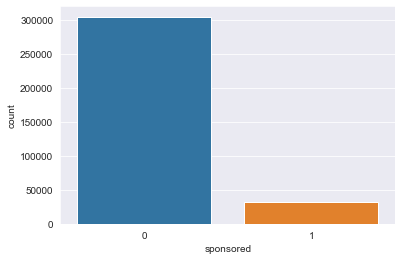

In [11]:
sns.countplot(data=df_file_labels, x='sponsored')

#### Text features viz

In [12]:
stop_words = set(stopwords.words('english') + \
                 stopwords.words('french') + \
                 stopwords.words('german') + \
                 stopwords.words('spanish')
                )
lemmer = WordNetLemmatizer()
text_transformer = TfidfVectorizer(max_features=250, ngram_range=(1, 2))
df['title'] = df['title'].fillna('')
df['title'] = df['title'].map(lambda x: x.lower())
df['title'] = df['title'].map(lambda x: re.sub(r'[^\w\s]', '', x))
df['title'] = df['title'].map(lambda x: re.sub(r'\d+', '', x))
df['title'] = df['title'].map(lambda x: [lemmer.lemmatize(word) for word in x.split() if word not in stop_words])
df['title'] = df['title'].map(lambda x: ' '.join(x))
text_vec = text_transformer.fit_transform(df['title'])

In [62]:
df_text = df[['sponsored']].join(pd.DataFrame(
    text_vec.toarray(), 
    columns=text_transformer.get_feature_names_out()
)
       )

In [144]:
df_t_grp = df_text.groupby(['sponsored']).sum().reset_index().T.reset_index()

In [158]:
df_t_grp = df_t_grp[1:]

In [145]:
df_t_grp = df_t_grp.rename({
    'index': 'word',
    0: 'not_sponsored', 
    1: 'sponsored'
}, axis=1)

In [146]:
df_t_nsp = df_t_grp.sort_values(by='not_sponsored', ascending = False)[:10]

In [147]:
df_t_sp = df_t_grp.sort_values(by='sponsored', ascending = False)[:10]

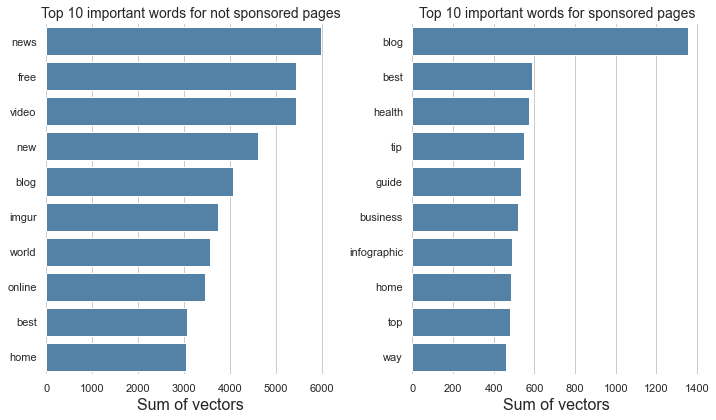

In [148]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
p1 = sns.barplot(x='not_sponsored', 
            y='word', 
            data=df_t_nsp,
            color='steelblue',
            ax=ax[0])
p2 = sns.barplot(x='sponsored', 
            y='word', 
            data=df_t_sp,
            color='steelblue',
            ax=ax[1])


p1.set_xlabel('Sum of vectors', fontsize=16)
p1.set_ylabel(None)
p1.set_title("Top 10 important words for not sponsored pages", fontsize=14)

p2.set_xlabel('Sum of vectors', fontsize=16)
p2.set_ylabel(None)
p2.set_title("Top 10 important words for sponsored pages", fontsize=14)
sns.despine(left=True, bottom=True)
fig.tight_layout()

In [151]:
scaler = MinMaxScaler()

In [162]:
df_t_grp[['sponsored', 'not_sponsored']] = scaler.fit_transform(df_t_grp[['sponsored', 'not_sponsored']])

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:3673: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._is_homogeneous_type and dtypes and is_extension_array_dtype(dtypes[0])


In [196]:
df_tidy = df_t_grp.melt(id_vars='word', var_name='type', value_name='scaled_vector_sum')

In [232]:
df_tidy = df_tidy[df_tidy['word'].isin(df_t_grp.sort_values(by='sponsored', ascending = False)[:10]['word'])]

In [233]:
df_tidy = df_tidy.sort_values(by=['type', 'scaled_vector_sum'], ascending=False)

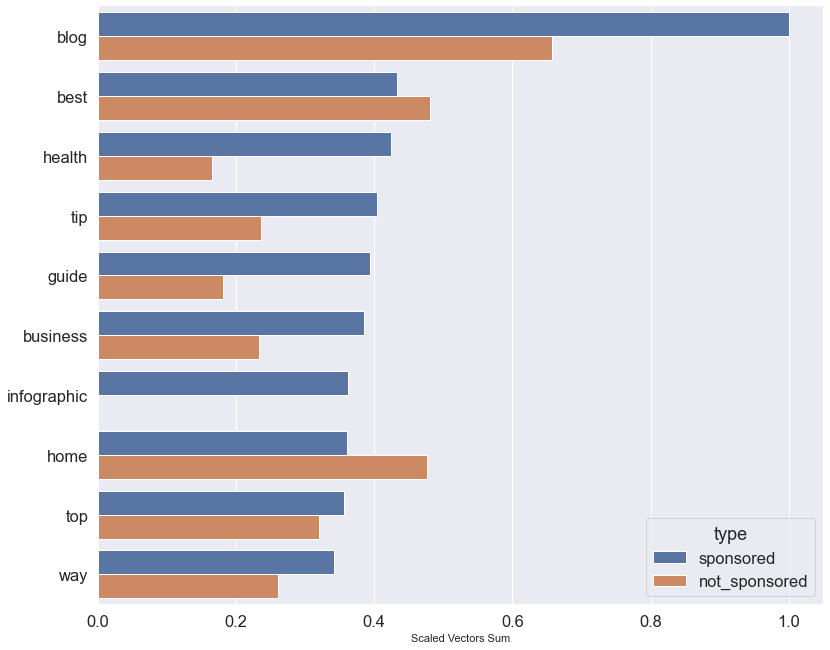

In [255]:
plt.figure(figsize=(13, 11))
s = sns.barplot(data=df_tidy, 
            x='scaled_vector_sum', 
            y='word', 
            hue='type')
s.set_xlabel('Scaled Vectors Sum', fontsize=11)
s.set_ylabel(None)
sns.set(font_scale = 1.5)
sns.despine(left=True, bottom=True)
plt.savefig('/users/oleh/Desktop/diff.svg', bbox_inches = 'tight')